# Libraries

In [39]:
# Importing and Loading libraries
import os
import pandas as pd
import numpy as np
from numpy import mean, std
from scipy import stats
from pandas import read_excel, read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
import random
import torch
import wget
import shap
import optuna
import logging
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, KFold, cross_validate, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import calibration_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
import sklearn.metrics as metrics
import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from skopt import BayesSearchCV
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Setting the limit of maximum printing record to None
pd.set_option('display.max_columns', None)

# Fetching Data

In [40]:
# Reading csv File as Dataframe
dataframe = pd.read_csv('csDMARD.csv',delimiter = ";", low_memory=False)

# Preprocessing

## Data Cleaning & Imputation

In [41]:
# Replacing the comma for numerical data with dot
# If regex is True then to_replace must be a string
df = dataframe.replace(to_replace=',', value='.', regex=True)


# Checking and Solving the consistancy for csDMARD_interval_unit Attribute
# print(df.csDMARD_interval_unit.unique())
df = df.replace({'every x days': 'x times a day', 'every x weeks': 'x times a week'})


# Convert visit_date to datetime 
# values that are not parsable to datatime will be assign as NaN / errors='coerce'
df['Visit_date'] = pd.to_datetime(df['Visit_date'], errors='coerce')


# NaN Percentage Sorting
"""
percent_missing = df.isnull().sum() * 100 / len(df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

"""


# Remove NaN value in visit_date
# All NaN value for visit_date was the last value for each patient which were by mistake and not fillable
df = df[df['Visit_date'].notna()]


# Sorting all df based on patient ID adn the date of the visit
df = df.sort_values(by=['tptID', 'Visit_date'])
df = df.reset_index(drop=True)


# Mapping gender to 0/1
df['Gender'] = df['Gender'].map(dict(f=1, m=0))


# Find columns contain  yes or no
# Convert yes, no to 0,1
df_columns_yn = [col for col in df.columns if df[col].isin(['yes', 'no']).any()]  # any(), it returns true  if any item in an iterable are true
df[df_columns_yn] = df[df_columns_yn].replace({'yes': 1, 'no': 0})
    

# Delete rows before the first taking csDMARD
# csDMARD is the first drug taken
df = df.groupby('tptID').apply(lambda x: x.loc[x[['csDMARD']].notna().idxmax()[0]:, :]).reset_index(drop=True)


# find interval between visit_date based on day (This calculates based on consecutive rows )
df['DateDiff'] = df.groupby('tptID')['Visit_date'].diff().apply(lambda x: x.days)
# find interval between visit_date based on day (This calculates based on first visit_date for each group )
df['DateDiff_N'] = df.groupby('tptID')['Visit_date'].apply(lambda x: (x - x.min())).dt.days
# find interval between visit_date based on month (This calculates based on first visit_date for each group )
df['DateDiff_NM'] = df.groupby('tptID')['Visit_date'].apply(lambda x: (x - x.min()) / np.timedelta64(1, 'M'))
df['DateDiff_NM'] = round(df['DateDiff_NM'], 1)  # Based on month


# List of disease
list_disease = ['Osteoarthritis', 'Asthma', 'Uveitis', 'Hypertension', 'Chronic_renal_insufficiency', 'COPD',
                'Depression', 'Diabetes', 'Inflammatory_bowel_disease', 'Fat_metabolism_disorder', 'Gout',
                'Heart_attack', 'Coronary_heart_disease', 'Osteoporosis', 'Periodontitis', 'Thyroid_disease',
                'Thrombosis']

# setting 0 for before and 1 for after the first announcement of disease
def set_disease(df, disease):
    
    for col in disease:

        ind = list()
        ind = df.index[df[col] == 1].tolist()
        
        if ind:
            df[col].loc[(df[col].idxmax()):] = 1
            df[col].loc[:((df[col].idxmax()) - 1)] = 0
        else:
            df[col].loc[:] = 0

    return df

# Apply set disease for each function
df = df.groupby('tptID').apply(lambda x: set_disease(x, list_disease))


# Imputation of Height and Weight
# fillna for Height and Weight
df[['Height_cm', 'Weight_kg']] = df.groupby('tptID')[['Height_cm', 'Weight_kg']].apply(lambda x: x.fillna(method='ffill'))
df[['Height_cm', 'Weight_kg']] = df.groupby('tptID')[['Height_cm', 'Weight_kg']].apply(lambda x: x.fillna(method='bfill'))

# For patients whose weight and height information is unavailable, an average value based on patients of the same gender and age
# has been used. These values were chosen by manually filtering the CSV file. # Median
df['Height_cm'] = np.where((df['Height_cm'].isnull()) & (df['Gender'] == 0), 177, df['Height_cm'])
df['Height_cm'] = np.where((df['Height_cm'].isnull()) & (df['Gender'] == 1), 165, df['Height_cm'])
df['Weight_kg'] = np.where((df['Weight_kg'].isnull()) & (df['Gender'] == 0), 86, df['Weight_kg'])
df['Weight_kg'] = np.where((df['Weight_kg'].isnull()) & (df['Gender'] == 1), 76, df['Weight_kg'])


# converting receiving Medicine to 0/1
df['csDMARD'] = np.where(~df['csDMARD'].isnull(), 1, 1)
df['tsDMARD'] = np.where(~df['tsDMARD'].isnull(), 1, 0)
df['bDMARD'] = np.where(~df['bDMARD'].isnull(), 1, 0)


# change object dtype to float
dtype_object = ['Weight_kg', 'HAQ_Score', 'DAS28BSG_Score', 'DAS28CRP_Score', 'CDAI_Score', 'SDAI_Score', 'CRP_mg_l', \
                'RF', 'CCP', 'bDMARD', 'bDMARD_dose_mg', 'tsDMARD', 'tsDMARD_dose_mg', 'tsDMARD_interval', \
                'csDMARD', 'csDMARD_dose_mg', 'csDMARD_interval', 'Prednisolone_dose_current',
                'Prednisolone_dose_long-term']
for dt in dtype_object:
    df[dt] = df[dt].astype(float)


# Change values of RF, CRP, CCP to 0 or 1 based on Medical standard
df['CRP_mg_l'] = np.where(df['CRP_mg_l'] < 5.2, 0, 1)
df['RF_b'] = np.where(df['RF'] < 20, 0, 1)
df['CCP_b'] = np.where(df['CCP'] < 14, 0, 1) 


# CCP should be considered 1 after the first time becoming 1(positive)
# Antibody exist  till the rest
df = df.groupby('tptID').apply(lambda x: set_disease(x, ['CCP']))


# fill nan as 0 for medicine_dose and interval that the medicine not taken
medicine_b_ts = ['bDMARD', 'tsDMARD']
for i in medicine_b_ts:
    df[f'{i}_dose_mg'] = np.where(df[i] == 0, df[f'{i}_dose_mg'].fillna(0), df[f'{i}_dose_mg'])
    df[f'{i}_interval'] = np.where(df[i] == 0, df[f'{i}_interval'].fillna(0), df[f'{i}_interval'])
    df[f'{i}_interval_unit'] = np.where(df[i] == 0, df[f'{i}_interval_unit'].fillna(0), df[f'{i}_interval_unit'])


# calculate total medicine_dose within a week
medicine = ['bDMARD', 'csDMARD', 'tsDMARD']
for i in medicine:
    # calculate total medicine_dose within a week
    conditions = [df[f'{i}_interval_unit'].str.contains('day', na=False),
                  df[f'{i}_interval_unit'].str.contains('week', na=False), 
                  df[f'{i}_interval_unit'] == 0]
    choices = [df[f'{i}_dose_mg'] * df[f'{i}_interval'] * 7, df[f'{i}_dose_mg'] * df[f'{i}_interval'], 0]
    df[f'{i}_dose_mg_week'] = np.select(conditions, choices)
    


# Creating column for BMI
df['BMI'] = df['Weight_kg'] / ((df['Height_cm'] / 100) ** 2)


# Dropping column contain String data, High NaN
df.drop(columns=['Prednisolone_dose_long-term','Weight_kg','Height_cm', 'DateDiff','Visit_date', 'DateDiff_N','Prednisolone_dose_current','bDMARD_dose_mg_week', 'csDMARD_dose_mg_week','tsDMARD_dose_mg_week','bDMARD_interval', 'bDMARD_interval_unit', 'csDMARD_interval','csDMARD_interval_unit','tsDMARD_interval_unit', 'bDMARD_dose_mg','csDMARD_dose_mg','RF_unit', 'CCP_unit'],inplace=True)


# Imputation of remaining columns with NaN
# Defining the Imputer
# Fitting and transorming the dataset with the imputer
# Set the maximum iteration to 15 to avoid IterativeImputer error for "early criterion not reached"
iter_imputer = IterativeImputer(max_iter=15)
impute = iter_imputer.fit_transform(df)
df_imputed = pd.DataFrame(impute, columns = df.columns)


# Renaming column DAS28BSG column name
df_imputed.rename(columns = {'DAS28BSG_Score':'DAS28ESR_Score'}, inplace = True)

# Create a copy of the dataframe
df_clean = df_imputed.copy()

## Labeling

In [42]:
# Writing loop to create sustain label

data_f = df_clean.groupby('tptID')
data_new = pd.DataFrame()


l=[]

for key_first in data_f.groups.keys():

    data_gr=data_f.get_group(key_first).reset_index()

    if (len(data_gr)>=3): # To have more than 3 records to do comparison

        for i in range (len (data_gr)-3): # Why just till record 3

            if data_gr.loc[i,'DateDiff_NM'] > 6:

                counter=0 
                n=0
                r=0
                if not (pd.isna(data_gr.loc[i,'DAS28ESR_Score'])) and not(pd.isna(data_gr.loc[i+1,'DAS28ESR_Score'])):
                    
                    if (data_gr.loc[i+1,'DateDiff_NM'] - data_gr.loc[i,'DateDiff_NM'])<=6: # It means there are two records that has les that 6 month interal and both has less than 3.2
                        r+=1
                        if (data_gr.loc[i,'DAS28ESR_Score']<3.2) and (data_gr.loc[i+1,'DAS28ESR_Score']<3.2):
                            n+=1
                        
                        counter+=1 
        
            
                       # The n counter is likely being used to keep track of the number of times the conditions are met
                       # The counter is likely being used to keep track of the number of records being checked


    else:
        data_gr.loc[i,'sustained']=0


    if n == counter: 
            data_gr.loc[:,'sustained']=1
            l.append(key_first)
    else:
            data_gr.loc[:,'sustained']=0
    

    data_new = data_new.append(data_gr)

# One missing value is interoduced in index 81
data_new = data_new.dropna(axis=0)

In [43]:
# Defining a function for Remission and Effectiveness labels

def labeling_re(dataset):

    data_g=dataset.groupby('tptID')
    data_new=pd.DataFrame(columns=dataset.columns)
    for c_key in (data_g.groups.keys()):
        

        data_group=data_g.get_group(c_key).reset_index()
        if len(data_group)>1:

            del_das = data_group['DAS28ESR_Score'].loc[0]-data_group['DAS28ESR_Score'].loc[len(data_group)-1]
            data_group.loc[0,'del_das'] = del_das

            das_current=data_group['DAS28ESR_Score'].loc[len(data_group)-1]
                    
                    
            if das_current<=2.6: 
                    data_group.loc[0,'remission']=1
                    data_group.loc[0,'effectiveness']=1 #Effectiveness : Remission and Low Disease Activity

            else:
                data_group.loc[0,'remission']=0
                if not(pd.isna(del_das)) and not(pd.isna(das_current)):
                            #good
                    if (das_current > 2.6) and (das_current <= 3.2 ):
                            data_group.loc[0,'effectiveness'] = 1
                            data_group.loc[0,'remission'] = 0
                    
                    elif(das_current > 3.2):
                            data_group.loc[0,'effectiveness'] = 0
                            data_group.loc[0,'remission'] = 0
            

            data_new=data_new.append(data_group.loc[0,:])
    return data_new


#data_new = labeling_re(df_clean)
#data_new = data_new.drop(columns=['index'])
#data_new = data_new.reset_index(drop=True)

# Best: Remission : DAS <2.6

# Low desease activity: LDA 2.6<DAS<3.2 

## EDA

In [44]:
# Creating a subset of the dataset only for the first six month visit
data_new_six=data_new[data_new.DateDiff_NM <= 6]
dataset_new_six=labeling_re(data_new_six)
dataset_new_six=dataset_new_six.reset_index(drop=True)
dataset_new_six=dataset_new_six.drop(columns=['index','level_0'])

In [45]:
#Assign zero for sustained for those which the effectiveness is zero
for row in range(len(dataset_new_six)-1):
    if  (dataset_new_six.loc[row,'effectiveness'].any())==0:
        if (dataset_new_six.loc[row,'sustained']==1):
            (dataset_new_six.loc[row,'sustained'])=0

In [46]:
# class distribution
print(dataset_new_six.groupby('effectiveness').size())
print(dataset_new_six.groupby('sustained').size())

effectiveness
0.0    133
1.0    197
dtype: int64
sustained
0.0    174
1.0    156
dtype: int64


In [47]:
# Creating subset of the dataset for features and target variables
dataset = dataset_new_six.copy()
target = ['remission','sustained','effectiveness']

# Filter columns to keep features
x = dataset.loc[:, ~dataset.columns.isin(target)].drop(['tptID','Uveitis','csDMARD_intake_duration_days','DateDiff_NM','del_das'], axis=1)

# Selecting label for training
y_effect = dataset.loc[:,'effectiveness']

## Normalization

In [48]:
# Min-Max Normalizing
X_normalized = (x - np.min(x)) / (np.max(x) - np.min(x)).values

# Imputing NaN number with zero
X_normalized.fillna(0,inplace=True)

## Imbalancing

In [49]:
# Imbalancing the Data to have balance for classes
smote = SMOTE(sampling_strategy="minority", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_normalized, y_effect)

In [79]:
# Setting NaN values to zero
y_train= np.nan_to_num(y_effect)

# label encode the target variable
y_train = LabelEncoder().fit_transform(y_train)

# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=197 (59.697%)
Class=0, n=133 (40.303%)


# Classification

In [58]:
# Selecting features and labels
X, y = X_resampled, y_resampled

# Converting them to numpy array to feed scikit-learn models
X = X.to_numpy()
y = y.to_numpy()

# Creating a dataframe to append all classifier evaluation information
data_classifier=pd.DataFrame(columns=['Classifier','Accuracy','AUC-ROC','F1 score','Recall'])

# Defining the k-fold cross-validation 
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Adaboost

### Grid_Search

>acc=0.734, est=0.759, cfg={'learning_rate': 1e-20, 'n_estimators': 1}
>acc=0.747, est=0.730, cfg={'learning_rate': 1e-20, 'n_estimators': 1}
>acc=0.785, est=0.724, cfg={'learning_rate': 1e-20, 'n_estimators': 1}
>acc=0.747, est=0.749, cfg={'learning_rate': 1e-20, 'n_estimators': 1}
>acc=0.744, est=0.760, cfg={'learning_rate': 1e-20, 'n_estimators': 1}
Accuracy: 0.751 (0.017)
Precision: 0.765 (0.035)
F1_Score: 0.746 (0.019)
Recall: 0.746 (0.019)
AUC-ROC: 0.746 (0.019)


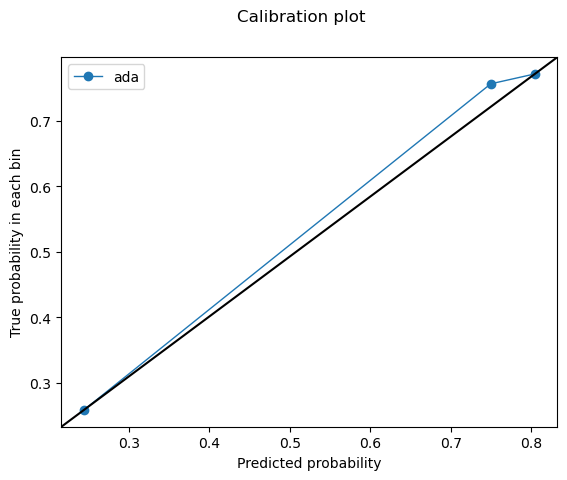

In [459]:
# Initialize the model with embedded feature selection
model = AdaBoostClassifier()


# define the grid of values to search
param_grid = { 
    'n_estimators' : [1,10,50],
    'learning_rate' : [1e-20,1e-19,1e-18,1e-17,1e-16,1e-15,1e-14,1e-13,1e-12]
    }


# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)

# Probability
kfold_probability = list()
kfold_true_label = list()


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
     
    # define search for hyperparameter tunning
    search = GridSearchCV(model, param_grid, scoring='accuracy', cv=inner_cv, refit=True)
    
    # fit the search with selected data
    result = search.fit(X_train_selected, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_   
    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)

    """
    # Apply SHAP value for XAI
    explainer = shap.TreeExplainer(best_model, iteration_range=100)
    shap_values = explainer(X_train_selected)
    shap.summary_plot(shap_values, X_train_selected, feature_names=selector.get_support(indices=True))

    # get the feature names
    selected_feature_names = X_resampled.columns[selector.get_support()]
    """

    # Probabilities calculation
    probas_ada = best_model.predict_proba(X_test_selected)
    y_proba = probas_ada[:, 1]

    # AUC-ROC calculation
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    
    # Evaluate the model
    acc_ada = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_ada = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_ada = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_ada = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_ada = roc_auc_score(y_test, y_proba)

    # store the result
    accuracy_result.append(acc_ada)
    recall_result.append(recall_ada)
    precision_result.append(precision_ada)
    f1_score_result.append(f1_ada)
    roc_auc_result.append(auc_ada)
    kfold_probability.append(probas_ada[:,1])
    kfold_true_label.append(y_test)

    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc_ada, result.best_score_, result.best_params_))


# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))


mean_tprs_ada = np.mean(tprs, axis=0)
mean_auc_ada = auc(mean_fpr, mean_tprs_ada)

# Calibration calculation
kfold_probability_stacked = np.hstack(kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)

#Plot calibration curves
ada_y, ada_x = calibration_curve(kfold_true_label_stacked, kfold_probability_stacked, n_bins=10)

fig, ax = plt.subplots()
plt.plot(ada_x, ada_y, marker='o', linewidth=1, label='ada')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

all_scores_ada = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'Adaboost'
}

# Create a DataFrame from the dictionary
score_df_ada = pd.DataFrame.from_dict(all_scores_ada)

### Optuna

In [68]:
# define the objective fucntion for Hyperparameter tunning
def objective(trial, X, y):

    # Defining model parameter
    params = {
        'algorithm': 'SAMME.R',
        'random_state': 42,
    }

    # Define the search spaces for the hyperparameters
    param_space = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 300),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-20, 1e-12,log = True)
    }
    
    # Defining traning model
    ada = AdaBoostClassifier(**params, **param_space)

    # Evaluation matrice
    scores = []
    
    # cross-validation splitting
    for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        ada.fit(X_train, y_train)
        y_pred = ada.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    return np.mean(scores)

In [69]:
# Initialize the model with embedded feature selection
model = AdaBoostClassifier()


# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()

# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)

# Probability
kfold_probability = list()
kfold_true_label = list()



# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
    
    # Running hyperparameter tunning
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    func = lambda trial: objective(trial, X_train_selected, y_train)
    study.optimize(func, n_trials=50)
    best_params = study.best_params
    

    # get the best performing model fit on the whole training set
    result = AdaBoostClassifier(**best_params)


    best_model = result.fit(X_train_selected, y_train)
    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)

   
     # Probabilities calculation
    probas_ada = best_model.predict_proba(X_test_selected)
    y_proba = probas_ada[:, 1]

    # AUC-ROC calculation
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    
    # Evaluate the model
    # Accuracy
    acc_ada = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_ada = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_ada = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_ada = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_ada = roc_auc_score(y_test, y_proba)


    # store the result
    accuracy_result.append(acc_ada)
    recall_result.append(recall_ada)
    precision_result.append(precision_ada)
    f1_score_result.append(f1_ada)
    roc_auc_result.append(auc_ada)
    kfold_probability.append(probas_ada[:,1])
    kfold_true_label.append(y_test)


# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))

# AUC-ROC calculation
mean_tprs_ada = np.mean(tprs, axis=0)
mean_auc_ada = auc(mean_fpr, mean_tprs_ada)


# Calibration calculation
kfold_probability_stacked = np.hstack(kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)

#Plot calibration curves
ada_y, ada_x = calibration_curve(kfold_true_label_stacked, kfold_probability_stacked, n_bins=10)


# Creating dictionary for result
all_scores_ada = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'Adaboost'
}

# Create a DataFrame from the dictionary
score_df_ada = pd.DataFrame.from_dict(all_scores_ada)

Accuracy: 0.751 (0.017)
Precision: 0.765 (0.035)
F1_Score: 0.746 (0.019)
Recall: 0.746 (0.019)
AUC-ROC: 0.746 (0.019)


In [70]:
score_df_ada

,Accuracy,AUC-ROC,precision,F1 score,Recall,Classifier
0,0.734177,0.675000,0.771429,0.720000,0.734936,Adaboost
1,0.746835,0.825000,0.717391,0.767442,0.745833,Adaboost
2,0.784810,0.717949,0.823529,0.767123,0.783974,Adaboost
3,0.746835,0.743590,0.743590,0.743590,0.746795,Adaboost
4,0.743590,0.692308,0.771429,0.729730,0.743590,Adaboost


## XGboost

### Grid_Search

In [80]:
# Initialize the model with embedded feature selection
model = XGBClassifier(verbosity=0, n_jobs=-1)

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)

# Shap-Value
fold=0
iter_shap = 0
indices = []
df_avg_train = []
df_avg_test = []


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
     
    # define search for hyperparameter tunning
    search = GridSearchCV(model, param_grid, scoring='accuracy', cv=inner_cv, refit=True)
    
    # fit the search with selected data
    result = search.fit(X_train_selected, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_   
    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)


    # Shap-value calculation
    selected_features = X_train.columns[selector.get_support()]
    
    train_tmp_df = pd.DataFrame(X_train_selected, columns = selected_features)
    explainer = shap.TreeExplainer(best_model, train_tmp_df,feature_perturbation='interventional', model_output='probability')
    df_shap_train = pd.DataFrame(explainer.shap_values(train_tmp_df),columns=selected_features)
    df_shap_train["index"] = train_ix
    df_avg_train.append(df_shap_train)

    """
    # Apply SHAP value for XAI
    explainer = shap.TreeExplainer(best_model, iteration_range=100)
    shap_values = explainer(X_train_selected)
    shap.summary_plot(shap_values, X_train_selected, feature_names=selector.get_support(indices=True))

    # get the feature names
    selected_feature_names = X_resampled.columns[selector.get_support()]
    """

     # AUC-ROC calculation
    y_proba = best_model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    
    # Evaluate the model
    acc_xgb = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_xgb = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_xgb = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_xgb = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_xgb = roc_auc_score(y_test, y_proba)

    # store the result
    accuracy_result.append(acc_xgb)
    recall_result.append(recall_xgb)
    precision_result.append(precision_xgb)
    f1_score_result.append(f1_xgb)
    roc_auc_result.append(auc_xgb)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))

# Shape Value
# Concatenate the dataframes into a single dataframe
concat_df_shap_train = pd.concat(df_avg_train)

# Compute the average of each column
avg_df_shap_train = concat_df_shap_train.groupby(concat_df_shap_train["index"]).mean()


mean_tprs_xgb = np.mean(tprs, axis=0)
mean_auc_xgb = auc(mean_fpr, mean_tprs_xgb)

all_scores_xgb = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'XGboost'
}

# Create a DataFrame from the dictionary
score_df_xgb = pd.DataFrame.from_dict(all_scores_xgb)

Accuracy: 0.746 (0.027)
Precision: 0.749 (0.040)
F1_Score: 0.746 (0.022)
Recall: 0.746 (0.022)
AUC-ROC: 0.746 (0.022)


### Optuna

In [66]:
# define the objective fucntion for Hyperparameter tunning
def objective(trial, X, y):

    # Define the model hyperparameters to optimize
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'verbosity': 0,  # Set verbosity to 0 for silent mode
        'tree_method': 'auto',
        'n_jobs': 1  # Set n_jobs to 1 for Optuna integration
    }
    
    # Define the search spaces for the hyperparameters
    param_space = {
        'eta': trial.suggest_float('eta', 1e-5, 1e-1, log = True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e2, log = True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e2)
    }
    
    # Train the XGBoost model with the selected hyperparameters
    xgb = XGBClassifier(**params, **param_space)

    # Evaluation Matrix
    scores = []
    
    # Splitting the cross-validation
    for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    return np.mean(scores)

In [67]:
# Initialize the model with embedded feature selection
model = XGBClassifier(verbosity=0, n_jobs=-1)

# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)

# Probability
kfold_probability = list()
kfold_true_label = list()
kfold_predicted_label = list()

# Shape-Value
df_avg_train = list()

# Confusion Matrix
true_label = list()
predicted_label = list()


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
    # Defing the studz for hyperparameter tunning
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    func = lambda trial: objective(trial, X_train_selected, y_train)
    study.optimize(func, n_trials=50)
    best_params = study.best_params
    

    # get the best performing model fit on the whole training set
    result = XGBClassifier(**best_params, verbosity=0)

    # Finding the best fit
    best_model = result.fit(X_train_selected, y_train)

    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)

    # Probabilities calculation
    probas_xgb = best_model.predict_proba(X_test_selected)
    y_proba = probas_xgb[:, 1]

    # AUC-ROC calculation
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Shap-value calculation
    selected_features = X_train.columns[selector.get_support()]
    train_tmp_df = pd.DataFrame(X_train_selected, columns = selected_features)
    explainer = shap.TreeExplainer(best_model, train_tmp_df,feature_perturbation='interventional', model_output='probability')
    df_shap_train = pd.DataFrame(explainer.shap_values(train_tmp_df),columns=selected_features)
    df_shap_train["index"] = train_ix

    
    # Evaluate the model
    acc_xgb = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_xgb = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_xgb = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_xgb = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_xgb = roc_auc_score(y_test, y_proba)

    # store the result
    accuracy_result.append(acc_xgb)
    recall_result.append(recall_xgb)
    precision_result.append(precision_xgb)
    f1_score_result.append(f1_xgb)
    roc_auc_result.append(auc_xgb)
    kfold_probability.append(probas_xgb[:,1])
    kfold_true_label.append(y_test)
    df_avg_train.append(df_shap_train)
    true_label.extend(y_test)
    predicted_label.extend(yhat)


# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))

# AUC-ROC
mean_tprs_xgb = np.mean(tprs, axis=0)
mean_auc_xgb = auc(mean_fpr, mean_tprs_xgb)

# Calibration calculation
kfold_probability_stacked = np.hstack(kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)

#Plot calibration curves
xgb_y, xgb_x = calibration_curve(kfold_true_label_stacked, kfold_probability_stacked, n_bins=10)


# Shape Value calculation
concat_df_shap_train = pd.concat(df_avg_train)
avg_df_shap_train_xgb = concat_df_shap_train.groupby(concat_df_shap_train["index"]).mean()


# Confusion Matrix
cm_xgb = confusion_matrix(true_label,predicted_label)


# Creating a dictionary for results
all_scores_xgb = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'XGboost'
}

# Create a DataFrame from the dictionary
score_df_xgb = pd.DataFrame.from_dict(all_scores_xgb)

Accuracy: 0.767 (0.019)
Precision: 0.778 (0.021)
F1_Score: 0.761 (0.025)
Recall: 0.761 (0.025)
AUC-ROC: 0.761 (0.025)


In [27]:
score_df_xgb

,Accuracy,AUC-ROC,precision,F1 score,Recall,Classifier
0,0.746835,0.700000,0.777778,0.736842,0.810897,XGboost
1,0.784810,0.800000,0.780488,0.790123,0.837179,XGboost
2,0.784810,0.717949,0.823529,0.767123,0.797436,XGboost
3,0.759494,0.743590,0.763158,0.753247,0.828846,XGboost
4,0.730769,0.717949,0.736842,0.727273,0.834320,XGboost


## LightGBM

### Optuna

In [62]:
# define the objective fucntion for Hyperparameter tunning
def objective(trial, X, y):

    # Define the search spaces for the hyperparameters
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 100,10000,step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 500, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15)
    }
    
    # Defining the model for tunning
    lgb = lgbm.LGBMClassifier(objective="binary", **param_grid,n_jobs=-1)

    # Evaluation matric
    scores = []
    
    # Cross-Validation splitting
    for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lgb.fit(X_train, y_train)
        y_pred = lgb.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    return np.mean(scores)

In [63]:
# Initialize the model for feature selection
model_feature = RandomForestClassifier(random_state=22, n_jobs=-1)


# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)

# Probability
kfold_probability = list()
kfold_true_label = list()


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model_feature, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
    # Create a study for hyperparameter tunnning
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    func = lambda trial: objective(trial, X_train_selected, y_train)
    study.optimize(func, n_trials=50)
    best_params = study.best_params
    
    
    # get the best performing model fit on the whole training set
    result = lgbm.LGBMClassifier(objective="binary", **best_params, n_jobs=-1)

    # Finding best fit
    best_model = result.fit(X_train_selected, y_train)
    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)


    # Probabilities calculation
    probas_gbm = best_model.predict_proba(X_test_selected)
    y_proba = probas_gbm[:, 1]

    # AUC-ROC calculation
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    
    # Evaluate the model
    acc_gbm = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_gbm = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_gbm = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_gbm = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_gbm = roc_auc_score(y_test, y_proba)

    # store the result
    accuracy_result.append(acc_gbm)
    recall_result.append(recall_gbm)
    precision_result.append(precision_gbm)
    f1_score_result.append(f1_gbm)
    roc_auc_result.append(auc_gbm)
    kfold_probability.append(probas_gbm[:,1])
    kfold_true_label.append(y_test)


# Summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))

# AUC-ROC
mean_tprs_gbm = np.mean(tprs, axis=0)
mean_auc_gbm = auc(mean_fpr, mean_tprs_gbm)

# Calibration calculation
kfold_probability_stacked = np.hstack(kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)

#Plot calibration curves
gbm_y, gbm_x = calibration_curve(kfold_true_label_stacked, kfold_probability_stacked, n_bins=10)

# Creating dictionary for reult
all_scores_gbm = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'lightgbm'
}

# Create a DataFrame from the dictionary
score_df_gbm = pd.DataFrame.from_dict(all_scores_gbm)

[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] min_gain_to_split is set=10.932662957895738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.932662957895738
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] min_gain_to_split is set=10.932662957895738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.932662957895738
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] min_gain_to_split is set=10.932662957895738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.932662957895738
[LightGBM] [Warning] lambda_l1

In [34]:
score_df_gbm

,Accuracy,AUC-ROC,precision,F1 score,Recall,Classifier
0,0.734177,0.675000,0.771429,0.720000,0.776923,lightgbm
1,0.746835,0.775000,0.738095,0.756098,0.825321,lightgbm
2,0.784810,0.717949,0.823529,0.767123,0.791667,lightgbm
3,0.746835,0.743590,0.743590,0.743590,0.753205,lightgbm
4,0.756410,0.743590,0.763158,0.753247,0.812952,lightgbm


## Random Forest

### Grid-Search

In [ ]:
# Initialize the model with embedded feature selection
model = RandomForestClassifier(random_state=22)


param_grid = { 
    'n_estimators': [1000,2000],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [1,2,3,4],
    'criterion' :['gini', 'entropy']
    }

# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
     
    # define search for hyperparameter tunning
    search = GridSearchCV(model, param_grid, scoring='accuracy', cv=inner_cv, refit=True)
    
    # fit the search with selected data
    result = search.fit(X_train_selected, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_   
    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)

    """
    # Apply SHAP value for XAI
    explainer = shap.TreeExplainer(best_model, iteration_range=100)
    shap_values = explainer(X_train_selected)
    shap.summary_plot(shap_values, X_train_selected, feature_names=selector.get_support(indices=True))

    # get the feature names
    selected_feature_names = X_resampled.columns[selector.get_support()]
    """

     # AUC-ROC calculation
    y_proba = best_model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    
    # Evaluate the model
    acc_rf = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_rf = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_rf = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_rf = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_rf = roc_auc_score(y_test, y_proba)

    # store the result
    accuracy_result.append(acc_rf)
    recall_result.append(recall_rf)
    precision_result.append(precision_rf)
    f1_score_result.append(f1_rf)
    roc_auc_result.append(auc_rf)


mean_tprs_rf = np.mean(tprs, axis=0)
mean_auc_rf = auc(mean_fpr, mean_tprs_rf)

all_scores_rf = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'Adaboost'
}

# Create a DataFrame from the dictionary
score_df_rf = pd.DataFrame.from_dict(all_scores_rf)

### Optuna

In [59]:
# define the objective fucntion for Hyperparameter tunning
def objective(trial, X, y):

    # Define the search spaces for the hyperparameters
    param_grid = {

        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    
    
    # Defining the model for tunning
    rf = RandomForestClassifier(**param_grid)

    # Evaluation matric
    scores = []
    
    # Cross-Validation splitting
    for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    return np.mean(scores)

In [61]:
# Initialize the model with embedded feature selection
model = RandomForestClassifier(random_state=22)

# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)

# Probability
kfold_probability = list()
kfold_true_label = list()


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
     
    # Create a study for hyperparameter tunnning
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    func = lambda trial: objective(trial, X_train_selected, y_train)
    study.optimize(func, n_trials=50)
    best_params = study.best_params
    
    
    # get the best performing model fit on the whole training set
    result = RandomForestClassifier(**best_params)

    # Finding best fit
    best_model = result.fit(X_train_selected, y_train)
    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)


    # Probabilities calculation
    probas_rf = best_model.predict_proba(X_test_selected)
    y_proba = probas_rf[:, 1]

    # AUC-ROC calculation
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    
    # Evaluate the model
    acc_rf = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_rf = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_rf = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_rf = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_rf = roc_auc_score(y_test, y_proba)

    # store the result
    accuracy_result.append(acc_rf)
    recall_result.append(recall_rf)
    precision_result.append(precision_rf)
    f1_score_result.append(f1_rf)
    roc_auc_result.append(auc_rf)
    kfold_probability.append(probas_rf[:,1])
    kfold_true_label.append(y_test)


# Summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))


# AUC-ROC
mean_tprs_rf = np.mean(tprs, axis=0)
mean_auc_rf = auc(mean_fpr, mean_tprs_rf)

# Calibration calculation
kfold_probability_stacked = np.hstack(kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)

#Plot calibration curves
rf_y, rf_x = calibration_curve(kfold_true_label_stacked, kfold_probability_stacked, n_bins=10)


# Creating a dictionary for result
all_scores_rf = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'Randomforest'
}

# Create a DataFrame from the dictionary
score_df_rf = pd.DataFrame.from_dict(all_scores_rf)

Accuracy: 0.761 (0.042)
Precision: 0.771 (0.047)
F1_Score: 0.758 (0.041)
Recall: 0.758 (0.041)
AUC-ROC: 0.758 (0.041)


## SVM

### Grid_Search

Accuracy: 0.738 (0.027)
Precision: 0.766 (0.036)
F1_Score: 0.725 (0.030)
Recall: 0.725 (0.030)
AUC-ROC: 0.725 (0.030)


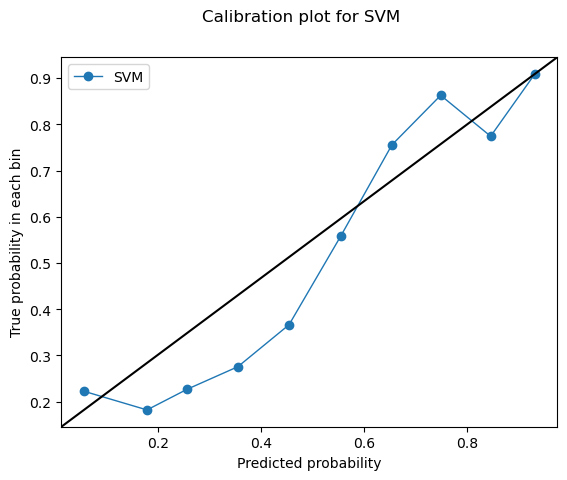

In [365]:
# Initialize the model for feature selection
model_feature = RandomForestClassifier(random_state=22)


param_grid = {'C': [1e-10,1e-5 ,0.1, 1e2, 1e5],
              'gamma': [1e-6,1e-4,0.001, 0.01, 1 , 100]}

# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()
svm_kfold_probability = list()
kfold_true_label = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):
    
    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    X_train = pd.DataFrame(X_train,columns=list(X_resampled.columns))
    X_test = pd.DataFrame(X_test,columns=list(X_resampled.columns))
    

    # Perform feature selection on the training data
    selector = SelectFromModel(model_feature, threshold='mean')
    selector.fit(X_train, y_train)


    # selection x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
     
    # define search for hyperparameter tunning
    search = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True), param_grid, scoring='accuracy', cv=inner_cv, refit=True)
    
    # fit the search with selected data
    result = search.fit(X_train_selected, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_   
    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)

    """
    # Apply SHAP value for XAI
    explainer = shap.TreeExplainer(best_model, iteration_range=100)
    shap_values = explainer(X_train_selected)
    shap.summary_plot(shap_values, X_train_selected, feature_names=selector.get_support(indices=True))

    # get the feature names
    selected_feature_names = X_resampled.columns[selector.get_support()]
    """

    # Probabilities
    probas_svc = best_model.predict_proba(X_test_selected)
    y_proba = probas_svc[:, 1]

    # AUC-ROC calculation
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Calibration
    # evaluate model on the hold out dataset
    probas_svc = best_model.predict_proba(X_test_selected)

    # extract the positive columns for each output
    auc_s = metrics.roc_auc_score(y_test, y_proba)


    # Evaluate the model
    acc_svm = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_svm = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_svm = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_svm = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_svm = roc_auc_score(y_test, y_proba)
    

    # store the result
    accuracy_result.append(acc_svm)
    recall_result.append(recall_svm)
    precision_result.append(precision_svm)
    f1_score_result.append(f1_svm)
    roc_auc_result.append(auc_svm)
    svm_kfold_probability.append(probas_svc[:,1])
    kfold_true_label.append(y_test)
    

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))


mean_tprs_svm = np.mean(tprs, axis=0)
mean_auc_svm = auc(mean_fpr, mean_tprs_svm)


svm_kfold_probability_stacked = np.hstack(svm_kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)

svm_y, svm_x = calibration_curve(kfold_true_label_stacked, svm_kfold_probability_stacked, n_bins=10)

##Plot calibration curves

fig, ax = plt.subplots()
plt.plot(svm_x, svm_y, marker='o', linewidth=1, label='SVM')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for SVM')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

all_scores_svm = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'SVM'
}

# Create a DataFrame from the dictionary
score_df_svm = pd.DataFrame.from_dict(all_scores_svm)

### Optuna

In [53]:
# Defining objective function for hyperparameter tunning
def objective(trial, X, y):

    # Defining model parameter
    params = {
        'kernel': 'rbf',
        'class_weight':'balanced',
        'random_state': 42,
    }
    
    # Define the search spaces for the hyperparameters
    param_space = {
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'gamma': trial.suggest_float('gamma', 1e-6, 1e6, log=True),
    }
    
    # Defining traning model
    svc = SVC(**params, **param_space)

    # Evaluation matrix
    scores = []
    
    # cross-validation splitting
    for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    return np.mean(scores)

In [54]:
# Initialize the model for feature selection
model_feature = RandomForestClassifier(random_state=22)


# validation matrices
accuracy_result = list()
precision_result = list()
f1_score_result = list()
recall_result = list()
roc_auc_result = list()


# AUC-ROC
tprs = list()
mean_fpr = np.linspace(0, 1, 100)


# Probability
kfold_probability = list()
kfold_true_label = list()


# Loop over each outer fold
for train_ix, test_ix in outer_cv.split(X,y):

    # Get the training and testing data for outer fold
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]


    # Perform feature selection on the training data
    selector = SelectFromModel(model_feature, threshold='mean')
    selector.fit(X_train, y_train)


    # Selecting x_train and x_test based on feature importance model
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
        
     
    # Running hyperparameter tunning
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    func = lambda trial: objective(trial, X_train_selected, y_train)
    study.optimize(func, n_trials=50)
    best_params = study.best_params


    # get the best performing model fit on the whole training set
    result = SVC(**best_params, probability=True, kernel = 'rbf', class_weight = 'balanced')


    # Finding the best model
    best_model = result.fit(X_train_selected, y_train)

    
    # Evaluate the model on the test data and calculate accuracy score
    yhat = best_model.predict(X_test_selected)


    # Probabilities calculation
    probas_svm = best_model.predict_proba(X_test_selected)
    y_proba = probas_svm[:, 1]

    # AUC-ROC calculation
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc_score = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))


    # Evaluate the model
    # # Accuracy
    acc_svm = accuracy_score(y_test, yhat)
    
    # Precision tp / (tp + fp)
    precision_svm = precision_score(y_test, yhat)
    
    # Recall: tp / (tp + fn)
    recall_svm = recall_score(y_test, yhat)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_svm = f1_score(y_test, yhat)
  
    # AUC-ROC
    auc_svm = roc_auc_score(y_test, y_proba)

    # store the result
    accuracy_result.append(acc_svm)
    recall_result.append(recall_svm)
    precision_result.append(precision_svm)
    f1_score_result.append(f1_svm)
    roc_auc_result.append(auc_svm)
    kfold_probability.append(probas_svm[:,1])
    kfold_true_label.append(y_test)


# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(accuracy_result), std(accuracy_result)))
print('Precision: %.3f (%.3f)' % (mean(precision_result), std(precision_result)))
print('F1_Score: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('Recall: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))
print('AUC-ROC: %.3f (%.3f)' % (mean(f1_score_result), std(f1_score_result)))

# AUC-ROC calculation
mean_tprs_svm = np.mean(tprs, axis=0)
mean_auc_svm = auc(mean_fpr, mean_tprs_svm)

# Calibration calculation
kfold_probability_stacked = np.hstack(kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)

#Plot calibration curves
svm_y, svm_x = calibration_curve(kfold_true_label_stacked, kfold_probability_stacked, n_bins=10)


# Creating dictionary for result
all_scores_svm = {

    'Accuracy': accuracy_result,
    'AUC-ROC': recall_result,
    'precision': precision_result,
    'F1 score':f1_score_result,
    'Recall':roc_auc_result,
    'Classifier':'SVM'
    
}

# Create a DataFrame from the dictionary
score_df_svm = pd.DataFrame.from_dict(all_scores_svm)

Accuracy: 0.726 (0.042)
Precision: 0.735 (0.055)
F1_Score: 0.722 (0.039)
Recall: 0.722 (0.039)
AUC-ROC: 0.722 (0.039)


In [55]:
score_df_svm

,Accuracy,AUC-ROC,precision,F1 score,Recall,Classifier
0,0.721519,0.750000,0.714286,0.731707,0.795513,SVM
1,0.734177,0.700000,0.756757,0.727273,0.728846,SVM
2,0.708861,0.692308,0.710526,0.701299,0.800000,SVM
3,0.797468,0.743590,0.828571,0.783784,0.838782,SVM
4,0.666667,0.666667,0.666667,0.666667,0.727811,SVM


In [ ]:
# create dataset

# Load data
# Normalize
target=['remission','del_das', 'effectiveness','effect_n']
#select all columns except 'col_nandata'
X=dataset.loc[:, ~dataset.columns.isin(target)].drop(['tptID', 'index','Uveitis','bDMARD_intake_duration_days','DateDiff_NM'], axis=1)


y_effect=dataset.loc[:,'effectiveness']
y = y_effect
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

# enumerate splits
acc_results_x = list()
precision_results_x= list()
F1_results_x = list()
recall_results_x = list()
aucroc_results_x = list()
aucs_x= list()
## save all crossvalidation results and then take the average of all of my data to make the calibration plot.
# store probability predictions and true labels here
x_kfold_probability = []
kfold_true_label_x = []

fig, ax = plt.subplots(figsize=(6, 6))

fold=0
iter_shap = 0
indices = []
df_avg_train = []
df_avg_test = []


for train_ix, test_ix in cv_outer.split(X):
    
    fold+=1
    
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    
    #feature selection
    model_rfc=rfc.fit(X_train, y_train)
    feature_importances = rfc.feature_importances_
    selected_features = np.where(feature_importances > 0.01)[0] # set a threshold for feature selection
    selected_features_list.append(selected_features)
   
    # subset the features in the training and test sets
    X_train_fs = X_train.iloc[:,selected_features]
    X_test_fs = X_test.iloc[:,selected_features]
    
    # define the model with default hyperparameters
    model = XGBClassifier(n_jobs=-1)
    
    # define the grid of values to search
    '''
    param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}
'''
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
    # define search
    search = GridSearchCV(model, params, scoring='accuracy', cv=cv_inner, refit=True)
    # define the evaluation procedure
    #cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
    # define the grid search procedure
    #grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
    # execute the grid search
    
    result = search.fit(X_train_fs, y_train)
    best_model = result.best_estimator_
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    
    
    y_pred_x = best_model.predict_proba(X_test_fs)[:, 1]
    
    # Compute and plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_x)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs_x.append(roc_auc)
    plt.plot(fpr, tpr, lw=1.5, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))
    
    # evaluate model on the hold out dataset
    probas_x = best_model.predict_proba(X_test_fs)

    yhat_x = best_model.predict(X_test_fs)
    
    # evaluate the model
    acc_x = accuracy_score(y_test, yhat_x)
    
    # precision tp / (tp + fp)
    precision_x= precision_score(y_test, yhat_x)
    
    # recall: tp / (tp + fn)
    recall_x = recall_score(y_test, yhat_x)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1_x = f1_score(y_test, yhat_x)
    
    #conf_matrix = confusion_matrix(y_test, yhat)
  
    
    # extract the positive columns for each output
    auc_x = metrics.roc_auc_score(y_test, probas_x[:,1])
    
    ##Calibration
    x_kfold_probability.append(probas_x[:,1])
    kfold_true_label_x.append(y_test)
    
    # store the result
    acc_results_x.append(acc_x)
    precision_results_x.append(precision_x)
    recall_results_x.append(recall_x)
    F1_results_x.append(f1_x)
    aucroc_results_x.append(auc_x)
    
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc_x, result.best_score_, result.best_params_))
    
    

    # Defining the SHAP value classifier()
    classifier_shap = nested_score['estimator'][iter_shap].named_steps['search'].best_estimator_
    classifier_shap.fit(X_train, y_train)


    ############## SHAP VALUES ################
    #model = classifier_shap.named_steps["classifier"]
    ### TRAINING DATA
    train_tmp_df = pd.DataFrame(X_train, columns = X.columns)
    explainer = shap.TreeExplainer(classifier_shap, train_tmp_df,feature_perturbation='interventional', model_output='probability')

    ### TEST DATA
    test_tmp_df = pd.DataFrame(X_test, columns = X.columns)
    test_explainer = shap.TreeExplainer(classifier_shap , test_tmp_df,feature_perturbation='interventional', model_output='probability')
    #explainer = shap.KernelExplainer(model.predict_proba, tmp_df,feature_perturbation='interventional', model_output='probability')


    #########################################################
    plt.figure()
    shap.summary_plot(explainer.shap_values(train_tmp_df),train_tmp_df, show=False)
    #plt.savefig(dir_name + '/plots/train_summary_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png',  bbox_inches = 'tight')
    plt.show()
    plt.close()
    plt.figure()
    shap.summary_plot(test_explainer.shap_values(test_tmp_df),test_tmp_df, show=False)
    #plt.savefig(dir_name + '/plots/test_summary_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
    plt.show()
    plt.close()

    plt.figure()
    shap.summary_plot(explainer.shap_values(train_tmp_df),train_tmp_df,plot_type="bar", show=False)
    #plt.savefig(dir_name +'/plots/train_summary_bar_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
    plt.show()
    plt.close()
    plt.figure()
    shap.summary_plot(test_explainer.shap_values(test_tmp_df),test_tmp_df, plot_type="bar",show=False)
    #plt.savefig(dir_name +'/plots/test_summary_bar_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
    plt.show()
    plt.close()
    #############################################################

    df_shap_train = pd.DataFrame(explainer.shap_values(train_tmp_df),columns=X.columns)
    df_shap_train["index"] = train_ix

    df_avg_train.append(df_shap_train)

    test_df_shap= pd.DataFrame(test_explainer.shap_values(test_tmp_df),columns=X.columns)
    test_df_shap["index"] = test_ix
    df_avg_test.append(test_df_shap)

    iter_shap += 1

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(acc_results_x), std(acc_results_x)))
print('Precision: %.3f (%.3f)' % (mean(precision_results_x), std(precision_results_x)))
print('F1_Score: %.3f (%.3f)' % (mean(F1_results_x), std(F1_results_x)))
print('Recall: %.3f (%.3f)' % (mean(recall_results_x), std(recall_results_x)))
print('AUC_ROC: %.3f (%.3f)' % (mean(aucroc_results_x), std(aucroc_results_x)))
#print('Confusion Matrix: %.3f (%.3f)' % (mean(conf_matrix_results), std(conf_matrix_results)))

#Trsults


all_scores_x = {

    "Accuracy":acc_results_x,
    'AUC-ROC':aucroc_results_x,
    'F1-Score':F1_results_x,
    'Classifier':'XGBoost'
}
all_scores_x = pd.DataFrame(all_scores_x)

# Plot the mean ROC curve across all folds
mean_tpr = np.mean(tprs, axis=0)
mean_auc_x = auc(mean_fpr, mean_tpr)
std_auc_x = np.std(aucs_x)

plt.plot(mean_fpr, mean_tpr, color='b', label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_x, std_auc_x), lw=2, alpha=.8)


# Plot the chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# Finalize the plot
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Nested Cross-Validation ROC Curve for XGBoost Classifier')
plt.legend(loc="lower right")
plt.savefig('roc_xgboost', dpi=300)

plt.show()

# Result

In [92]:
# Concatinate all results
data_classifier_result = pd.concat([data_classifier, score_df_ada, score_df_xgb, score_df_gbm, score_df_rf, score_df_svm], ignore_index=True)
data_classifier_result

,Classifier,Accuracy,AUC-ROC,F1 score,Recall,precision
0,Adaboost,0.734177,0.675000,0.720000,0.734936,0.771429
1,Adaboost,0.746835,0.825000,0.767442,0.745833,0.717391
2,Adaboost,0.784810,0.717949,0.767123,0.783974,0.823529
3,Adaboost,0.746835,0.743590,0.743590,0.746795,0.743590
4,Adaboost,0.743590,0.692308,0.729730,0.743590,0.771429
5,XGboost,0.784810,0.775000,0.784810,0.824359,0.794872
6,XGboost,0.784810,0.800000,0.790123,0.841026,0.780488
7,XGboost,0.759494,0.692308,0.739726,0.857692,0.794118
8,XGboost,0.734177,0.717949,0.727273,0.834936,0.736842
9,XGboost,0.769231,0.743590,0.763158,0.836949,0.783784


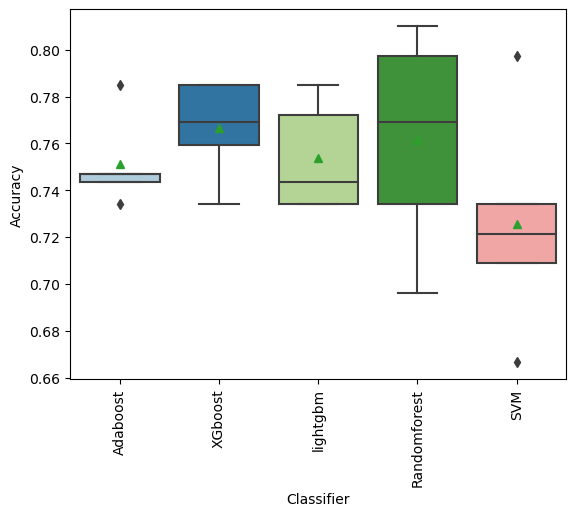

In [74]:
box_words = sns.boxplot(x='Classifier', y='Accuracy', data=data_classifier_result ,showmeans=True, palette= 'Paired')
box_words.set_xticklabels(box_words.get_xticklabels(),rotation=90)

#fig_words = box_words.get_figure()
plt.savefig('Accuracy_classifier_bdmard6.png',dpi=300,bbox_inches='tight')

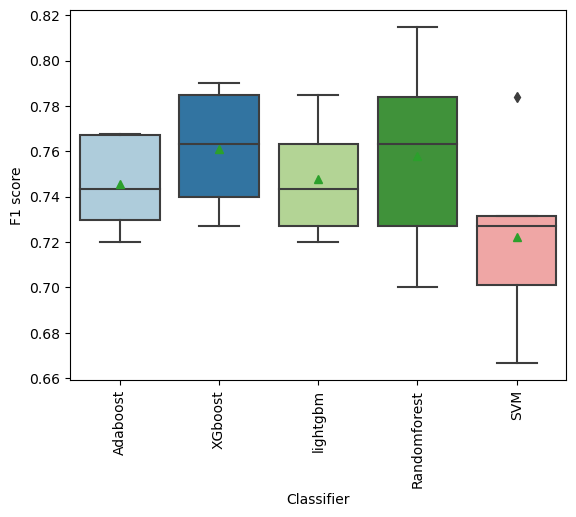

In [75]:
box_words = sns.boxplot(x='Classifier', y='F1 score', data=data_classifier_result ,showmeans=True, palette= 'Paired')
box_words.set_xticklabels(box_words.get_xticklabels(),rotation=90)
fig_words = box_words.get_figure()
plt.savefig('F1score_classifier_bdmard6.png',dpi=300,bbox_inches='tight')

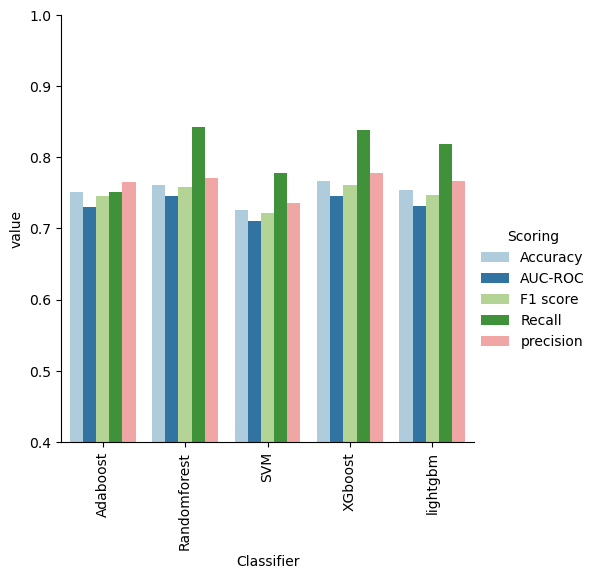

In [95]:
import seaborn as sns

data_plot_clc=(data_classifier_result.groupby('Classifier').mean()).reset_index()
#data_plot_clc.rename(columns={'AUCC-ROC' : 'AUC_ROC'},inplace=True)


df_list=[]

data=data_plot_clc.melt(id_vars=['Classifier'],var_name='Scoring')
data['type']=1
df_list.append(data)
df=pd.concat(df_list)
g = sns.catplot(data=df,
                x="Classifier", y="value",hue="Scoring",kind="bar",palette=sns.color_palette("Paired"))
g.set_xticklabels(rotation=90)
g.set(ylim=(0.4, 1))

plt.savefig('mean_classification6.png',dpi=300,bbox_inches='tight')

In [96]:
data_plot_clc[["Accuracy", "AUC-ROC", "F1 score", "Recall", "precision"]] = data_plot_clc[["Accuracy", "AUC-ROC", "F1 score", "Recall", "precision"]].round(3)

In [97]:
data_plot_clc

,Classifier,Accuracy,AUC-ROC,F1 score,Recall,precision
0,Adaboost,0.751,0.731,0.746,0.751,0.765
1,Randomforest,0.761,0.746,0.758,0.842,0.771
2,SVM,0.726,0.711,0.722,0.778,0.735
3,XGboost,0.767,0.746,0.761,0.839,0.778
4,lightgbm,0.754,0.731,0.748,0.819,0.766


In [98]:
data_plot_clc.to_csv("evaluation.csv")

### ROC Curve

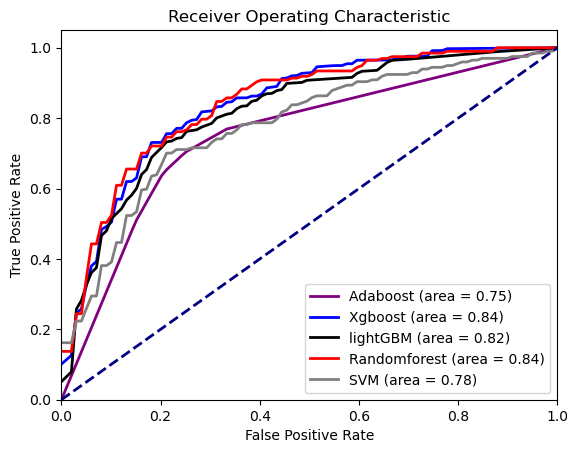

In [80]:
# plot the ROC curves for each model
plt.figure()
plt.plot(mean_fpr, mean_tprs_ada, color='purple', lw=2, label='Adaboost (area = %0.2f)' % mean_auc_ada)
plt.plot(mean_fpr, mean_tprs_xgb, color='blue', lw=2, label='Xgboost (area = %0.2f)' % mean_auc_xgb)
plt.plot(mean_fpr, mean_tprs_gbm, color='black', lw=2, label='lightGBM (area = %0.2f)' % mean_auc_gbm)
plt.plot(mean_fpr, mean_tprs_rf, color='red', lw=2, label='Randomforest (area = %0.2f)' % mean_auc_rf)
plt.plot(mean_fpr, mean_tprs_svm, color='gray', lw=2, label='SVM (area = %0.2f)' % mean_auc_svm)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('AUC-ROC.png',dpi=300,bbox_inches='tight')
plt.show()

### Calibration Plot

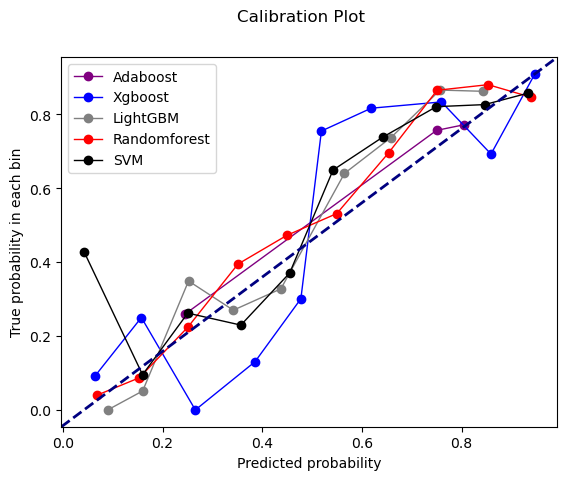

In [72]:
## Plot Calibration Curve
fig, ax = plt.subplots()
plt.plot(ada_x, ada_y, color='purple', marker='o', linewidth=1, label='Adaboost')
plt.plot(xgb_x, xgb_y, color='blue', marker='o', linewidth=1, label='Xgboost')
plt.plot(gbm_x, gbm_y, color='gray', marker='o', linewidth=1, label='LightGBM')
plt.plot(rf_x, rf_y, color='red', marker='o', linewidth=1, label='Randomforest')
plt.plot(svm_x, svm_y, color='black', marker='o', linewidth=1, label='SVM')



# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration Plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

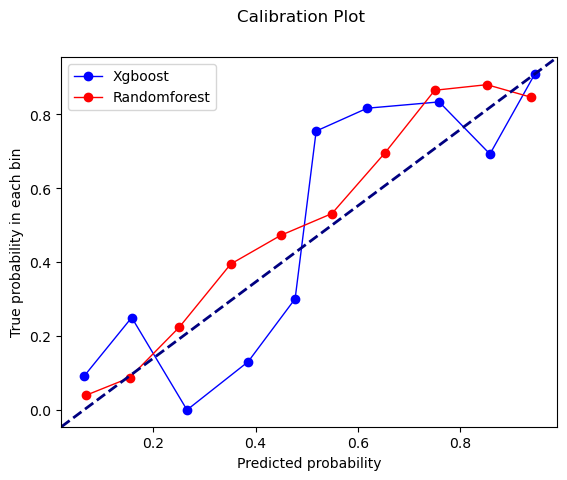

In [82]:
## Plot Calibration Curve
fig, ax = plt.subplots()
plt.plot(xgb_x, xgb_y, color='blue', marker='o', linewidth=1, label='Xgboost')
plt.plot(rf_x, rf_y, color='red', marker='o', linewidth=1, label='Randomforest')




# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration Plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.savefig('Calibration.png',dpi=300,bbox_inches='tight')
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

### Shaply Plot

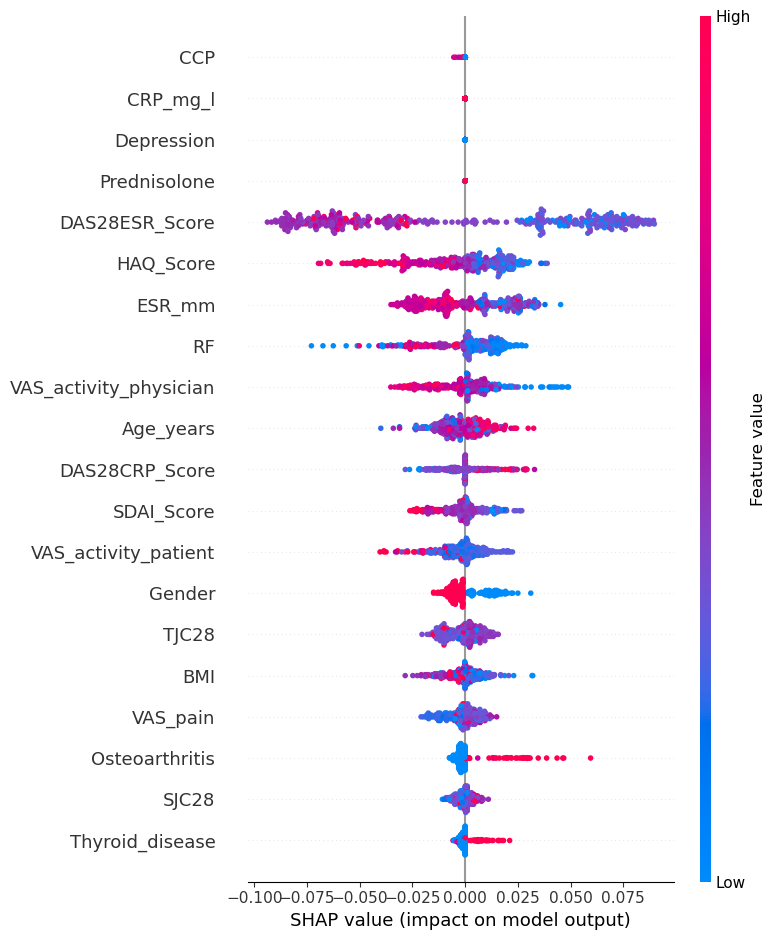

In [104]:
# convert the DataFrame to a numpy array
shap_values_xgb = avg_df_shap_train_xgb.values

# create a list of feature names
feature_names_xgb = list(avg_df_shap_train_xgb.columns)

X_shap = pd.DataFrame(X, columns = list(X_resampled))
X_shap_xgb = X_shap.loc[:,feature_names_xgb]

# create a summary plot
plt.figure()
shap.summary_plot(shap_values_xgb, X_shap_xgb, feature_names=feature_names_xgb,show=False)
plt.savefig('summary_plot.png',bbox_inches='tight')
plt.show()

### Confusion Matrix

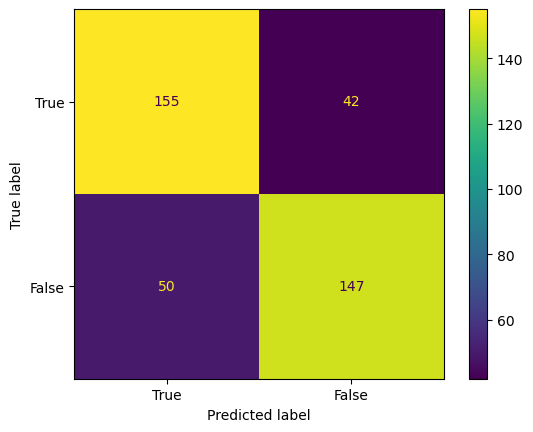

In [100]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = [True, False])
cm_display.plot()
plt.savefig('Confusion_Matrix.png',dpi=300,bbox_inches='tight')
plt.show()